### Imports & Configuration

Import essential libraries for data processing, visualization, and machine learning.


In [55]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CatBoost
from catboost import CatBoostRegressor

# Explainability
import shap

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Why CatBoost?

We chose CatBoost because our dataset contains many high-cardinality categorical features such as district, developer, building, and complex identifiers, and CatBoost handles categorical variables natively using ordered target encoding without requiring manual one-hot encoding or heavy preprocessing. This reduces target leakage, prevents overfitting, and keeps the pipeline clean and production-ready. Since real estate pricing is a structured tabular regression problem with mixed numerical and categorical data, gradient boosting trees perform very well, and CatBoost is specifically optimized for such data. Compared to LightGBM and XGBoost, it was more stable on our dataset and required less feature engineering while delivering strong validation performance.

### Data Loading

Load the primary dataset from `case_data.csv`.


In [56]:
df = pd.read_csv("case_data.csv", encoding="utf-8")

### Initial Inspection

Display dataset shape and the first record to understand the structure.


In [57]:
print("Shape:", df.shape)
df.head(1)

Shape: (59310, 40)


,District,Address,Class,HouseNumber,Building,Plot,FloorsTotal,HandoverDate,Phase,BuildingType,...,LivingArea,KitchenArea,HallwayArea,BathroomArea,BalconyArea,PlotArea,PricePerMeter,TotalCost,Developer_encoded,Complex_encoded
0,МО Ленинский г.о.,"Сапроново д., Калиновая ул.",Комфорт,NaN,1,NaN,25,Сдан,1,Монолит,...,43.7,12.2,13.5,"3,4с+1,3т","3,4л",0.0,266300.0,20265430.0,Developer58,Complex0


### Data Schema Overview

Check column types and non-null counts to identify data types and potential gaps.


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59310 entries, 0 to 59309
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            59310 non-null  object 
 1   Address             59310 non-null  object 
 2   Class               59310 non-null  object 
 3   HouseNumber         1650 non-null   object 
 4   Building            59219 non-null  object 
 5   Plot                3061 non-null   object 
 6   FloorsTotal         59310 non-null  int64  
 7   HandoverDate        59310 non-null  object 
 8   Phase               59310 non-null  int64  
 9   BuildingType        59310 non-null  object 
 10  InstallmentUntil    5 non-null      object 
 11  InstallmentMonths   636 non-null    float64
 12  Number              59310 non-null  object 
 13  PIBNumber           136 non-null    object 
 14  LayoutType          93 non-null     object 
 15  Axis                0 non-null      float64
 16  Floo

### Feature Selection (Dropping Columns)

Remove irrelevant or redundant columns to simplify the model.


In [59]:
drop_cols = [
    "Axis",
    "InstallmentUntil",
    "InstallmentMonths",
    "PIBNumber",
    "LayoutType",
    "HouseNumber",
    "Plot",
    "Address",
    "Number"
]

df = df.drop(columns=drop_cols)

print("New shape:", df.shape)

New shape: (59310, 31)


### Data Quality Check (Nulls)

Identify columns with missing values to prioritize cleaning steps.


In [60]:
df.isnull().sum().sort_values(ascending=False).head(10)

Building        91
District         0
Class            0
FloorsTotal      0
HandoverDate     0
Phase            0
BuildingType     0
Floor            0
Section          0
PropertyType     0
dtype: int64

### Numeric Extraction

Parse numeric values from string fields like `BathroomArea` and `BalconyArea` using regex.


In [61]:
import re

def extract_numeric(value):
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r"\d+\.\d+|\d+", str(value))
    if numbers:
        return sum(float(n) for n in numbers)
    return np.nan

df["BathroomArea"] = df["BathroomArea"].apply(extract_numeric)
df["BalconyArea"] = df["BalconyArea"].apply(extract_numeric)

### Type Conversion

Ensure all area-related and cost-related columns are explicitly cast to numeric types.


In [62]:
area_columns = [
    "TotalArea",
    "AreaWithoutBalcony",
    "LivingArea",
    "KitchenArea",
    "HallwayArea",
    "BathroomArea",
    "BalconyArea",
    "PlotArea",
    "PricePerMeter",
    "TotalCost",
    "CeilingHeight"
]

for col in area_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

### Refined Feature Quality Check

Re-evaluate missing values after initial cleaning phase.


In [63]:
df.isnull().sum().sort_values(ascending=False).head(10)

Building        91
District         0
Class            0
FloorsTotal      0
HandoverDate     0
Phase            0
BuildingType     0
Floor            0
Section          0
PropertyType     0
dtype: int64

### Missing Value Imputation

Fill missing building identifiers with placeholder value "Unknown".


In [64]:
df["Building"] = df["Building"].fillna("Unknown")

### Target Refinement

Drop records where the target variable (`PricePerMeter`) is missing.


In [65]:
df = df.dropna(subset=["PricePerMeter"])

### Outlier Mitigation

Filter out top 1% outliers in `PricePerMeter` to improve model stability.


In [66]:
upper_limit = df["PricePerMeter"].quantile(0.99)
df = df[df["PricePerMeter"] < upper_limit]

### Target Transformation (Log)

Apply log transformation to the target variable to stabilize variance and normalize the distribution.


In [67]:
df["target"] = np.log(df["PricePerMeter"])

### Target Visualization

Plot the histogram of the log-transformed target to verify normality.


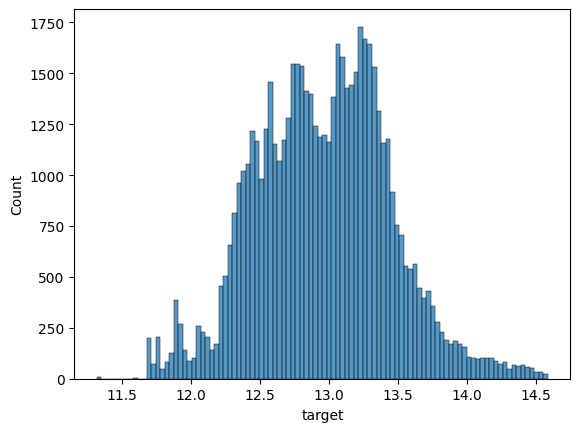

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["target"], bins=100)
plt.show()

### Feature Matrix (X) & Target (y) Split

Isolate the target variable from predictor features.


In [69]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

print("Feature shape:", X.shape)

Feature shape: (58716, 30)


### Categorical Feature Identification

Automatically detect object-type columns that represent categories.


In [70]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical Features:")
print(cat_features)
print("Count:", len(cat_features))

Categorical Features:
['District', 'Class', 'Building', 'HandoverDate', 'BuildingType', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded']
Count: 17


### Null Check in Features

Verify missing values in the feature matrix.


In [71]:
X.isnull().sum().sort_values(ascending=False).head(10)

District        0
Class           0
Building        0
FloorsTotal     0
HandoverDate    0
Phase           0
BuildingType    0
Floor           0
Section         0
PropertyType    0
dtype: int64

### Uniqueness Check

Examine cardinality of categorical features.


In [72]:
for col in cat_features:
    print(col, "→ unique:", X[col].nunique())

District → unique: 111
Class → unique: 4
Building → unique: 498
HandoverDate → unique: 19
BuildingType → unique: 6
Section → unique: 78
PropertyType → unique: 15
PropertyCategory → unique: 8
Apartments → unique: 2
Finishing → unique: 6
Status → unique: 1
ApartmentOption → unique: 2
Mortgage → unique: 2
Subsidies → unique: 2
Layout → unique: 2
Developer_encoded → unique: 109
Complex_encoded → unique: 395


### Null Check in Features (Verification)

Final check for missing values in X.


In [73]:
print("Total missing in X:", X.isnull().sum().sum())

Total missing in X: 0


### Final Missing Value Cleanup

Replace remaining NaNs in features with "Missing" or numeric 0.


In [74]:
X = X.fillna("Missing")

# For numeric columns, convert back properly
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")

X = X.fillna(0)

### Null Check in Target

Final check for missing values in y.


In [75]:
print("Missing in y:", y.isnull().sum())

Missing in y: 0


### Categorical Indexing

Identify integer indices of categorical columns for CatBoost compatibility.


In [76]:
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features]
print(cat_feature_indices)

[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 28, 29]


### Categorical Type Casting

Ensure categorical columns have the correct pandas dtype.


In [77]:
for col in cat_features:
    X[col] = X[col].astype("category")

### Dataset Validation (Statistics)

Check for zero or negative values in the price column.


In [78]:
print("Min PricePerMeter:", df["PricePerMeter"].min())
print("Max PricePerMeter:", df["PricePerMeter"].max())
print("Any zeros:", (df["PricePerMeter"] == 0).sum())
print("Any negative:", (df["PricePerMeter"] < 0).sum())

Min PricePerMeter: 0.0
Max PricePerMeter: 2165000.0
Any zeros: 4
Any negative: 0


### Target Statistics

Verify min/max values of the target variable.


In [79]:
print("Target min:", df["target"].min())
print("Target max:", df["target"].max())

Target min: -inf
Target max: 14.587930919418728


### Cleaning Zero Prices

Remove rows with zero prices to allow log transformation.


In [80]:
df = df[df["PricePerMeter"] > 0]

### Target Transformation (Verification)

Re-apply log transformation to clean target.


In [81]:
df["target"] = np.log(df["PricePerMeter"])

### Target Statistics (Final)

Final verification of target range.


In [82]:
print("Target min:", df["target"].min())
print("Target max:", df["target"].max())

Target min: 11.318029176594122
Target max: 14.587930919418728


### Feature/Target Split (Final)

Prepare final X and y sets.


In [83]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

### Categorical Type Casting (Verification)

Ensure categories are set correctly.


In [84]:
for col in cat_features:
    X[col] = X[col].astype("category")

### Target Validation (Verification)

Check for infinite values in the target.


In [85]:
print("Any -inf in target:", np.isinf(y).sum())
print("Target min:", y.min())

Any -inf in target: 0
Target min: 11.318029176594122


### Feature Pruning

Remove problematic features like `HandoverDate` to optimize input space.


In [86]:
# Remove problematic column
if "HandoverDate" in X.columns:
    X = X.drop(columns=["HandoverDate"])

# Also remove from categorical list if present
cat_features = [col for col in cat_features if col != "HandoverDate"]

print("HandoverDate removed.")

HandoverDate removed.


### Train-Test-Validation Split

Divide data into training (70%), validation (15%), and testing (15%) subsets.


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

### Schema Export

Save the list of model features to `model_features.json`.


In [88]:
import json

feature_list = list(X.columns)

with open("model_features.json", "w") as f:
    json.dump(feature_list, f)

print("Feature list saved.")

Feature list saved.


### Feature/Target Split (Re-init)

Refresh X and y for training.


In [89]:
X = df.drop(columns=["PricePerMeter", "target"])
y = df["target"]

### Feature Overview

Display current list of features.


In [90]:
print(X.columns)

Index(['District', 'Class', 'Building', 'FloorsTotal', 'HandoverDate', 'Phase',
       'BuildingType', 'Floor', 'Section', 'PropertyType', 'PropertyCategory',
       'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage',
       'Subsidies', 'Layout', 'CeilingHeight', 'TotalArea',
       'AreaWithoutBalcony', 'LivingArea', 'KitchenArea', 'HallwayArea',
       'BathroomArea', 'BalconyArea', 'PlotArea', 'TotalCost',
       'Developer_encoded', 'Complex_encoded'],
      dtype='object')


### HandoverDate Pruning

Final removal of HandoverDate.


In [91]:
X = X.drop(columns=["HandoverDate"], errors="ignore")

### Categorical Feature List

Identified categories for training.


In [92]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

### Final Split

Final Train/Val/Test split preparation.


In [93]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

### Model Training (CatBoost)

Initialize and train the `CatBoostRegressor` with RMSE loss.


In [94]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

0:	learn: 0.4701844	test: 0.4661524	best: 0.4661524 (0)	total: 51.2ms	remaining: 51.2s
100:	learn: 0.0881276	test: 0.0864450	best: 0.0864450 (100)	total: 6.82s	remaining: 1m
200:	learn: 0.0513171	test: 0.0518228	best: 0.0518228 (200)	total: 13.2s	remaining: 52.5s
300:	learn: 0.0368616	test: 0.0385974	best: 0.0385974 (300)	total: 19.5s	remaining: 45.2s
400:	learn: 0.0296183	test: 0.0322814	best: 0.0322814 (400)	total: 25.8s	remaining: 38.5s
500:	learn: 0.0252150	test: 0.0283912	best: 0.0283912 (500)	total: 32s	remaining: 31.9s
600:	learn: 0.0222561	test: 0.0258785	best: 0.0258785 (600)	total: 38.2s	remaining: 25.4s
700:	learn: 0.0199972	test: 0.0242227	best: 0.0242227 (700)	total: 44.5s	remaining: 19s
800:	learn: 0.0183643	test: 0.0230074	best: 0.0230074 (800)	total: 50.8s	remaining: 12.6s
900:	learn: 0.0171089	test: 0.0220726	best: 0.0220726 (900)	total: 57.3s	remaining: 6.29s
999:	learn: 0.0161993	test: 0.0213704	best: 0.0213704 (999)	total: 1m 3s	remaining: 0us

bestTest = 0.02137036

# Model Performance Metrics

We evaluate the model using:

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² Score

In [95]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds_log = model.predict(X_test)
preds = np.exp(preds_log)
y_true = np.exp(y_test)

mae = mean_absolute_error(y_true, preds)
rmse = np.sqrt(mean_squared_error(y_true, preds))
r2 = r2_score(y_true, preds)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 6385.954790519912
RMSE: 15368.631796483136
R2: 0.9963859578281594


### Price Context

Calculate mean price for error comparison.


In [96]:
print(df["PricePerMeter"].mean())

479970.51611024485


### Feature Importance (SHAP)

Interpret model predictions using SHAP values.


In [97]:
explainer = shap.TreeExplainer(model)
sample = X_test.iloc[0:1]
shap_values = explainer.shap_values(sample)

shap_df = pd.DataFrame({
    "feature": X.columns,
    "impact": shap_values[0]
}).sort_values(by="impact", key=abs, ascending=False)

shap_df.head(10)

,feature,impact
26,TotalCost,0.405612
0,District,0.092331
18,TotalArea,-0.078798
17,CeilingHeight,0.011024
1,Class,-0.008885
27,Developer_encoded,0.006762
8,PropertyType,0.004126
28,Complex_encoded,0.002461
19,AreaWithoutBalcony,0.001083
4,Phase,0.000996


### Model Persistence

Save the trained model to `.cbm` format.


In [98]:
model.save_model("catboost_price_model_final.cbm")

### Inference Test

Run single-sample prediction to verify the pipeline.


In [99]:
import numpy as np

sample = X_test.iloc[0].to_dict()

pred_log = model.predict(pd.DataFrame([sample]))
pred_price = np.exp(pred_log)[0]

actual_price = np.exp(y_test.iloc[0])

print("Predicted PricePerMeter:", round(pred_price, 2))
print("Actual PricePerMeter:", round(actual_price, 2))
print("Absolute Error:", round(abs(pred_price - actual_price), 2))

Predicted PricePerMeter: 657166.64
Actual PricePerMeter: 666475.01
Absolute Error: 9308.37


### Metadata Verification

Review final feature count and list.


In [100]:
print("Final feature count:", len(X.columns))
print(X.columns.tolist())

Final feature count: 29
['District', 'Class', 'Building', 'FloorsTotal', 'Phase', 'BuildingType', 'Floor', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'CeilingHeight', 'TotalArea', 'AreaWithoutBalcony', 'LivingArea', 'KitchenArea', 'HallwayArea', 'BathroomArea', 'BalconyArea', 'PlotArea', 'TotalCost', 'Developer_encoded', 'Complex_encoded']


### Final Schema Save

Ensure `model_features.json` is updated with exact feature order.


In [101]:
import json

final_features = list(X.columns)

with open("model_features.json", "w") as f:
    json.dump(final_features, f, indent=4)

print("Updated model_features.json saved.")

Updated model_features.json saved.


### Categorical Metadata Export

Save category list for backend configuration.


In [102]:
import json

with open("categorical_features.json", "w") as f:
    json.dump(cat_features, f)

print("categorical_features.json saved.")

categorical_features.json saved.


### Categorical Verification

Final count of categorical features.


In [103]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical features:")
print(cat_features)
print("Count:", len(cat_features))

Categorical features:
['District', 'Class', 'Building', 'BuildingType', 'Section', 'PropertyType', 'PropertyCategory', 'Apartments', 'Finishing', 'Status', 'ApartmentOption', 'Mortgage', 'Subsidies', 'Layout', 'Developer_encoded', 'Complex_encoded']
Count: 16


### Final Metadata Export

Save categorical features with indentation for readability.


In [104]:
import json

with open("categorical_features.json", "w") as f:
    json.dump(cat_features, f, indent=4)

print("categorical_features.json saved successfully.")

categorical_features.json saved successfully.


### Actual vs Predicted Price Scatter Plot

This visualization shows the relationship between actual and predicted prices per square meter (in Rubles).

**Plot Interpretation:**
- **Blue dots**: Individual predictions from our test set
- **Red diagonal line**: Perfect predictions (actual = predicted)
- **Closer to red line**: More accurate predictions
- **Above red line**: Model overestimated the price
- **Below red line**: Model underestimated the price

**What to look for:**
- Tight clustering around the diagonal line indicates good model performance
- Systematic patterns (e.g., all dots above line at certain price ranges) might indicate bias
- Outliers far from the diagonal represent cases where the model struggled

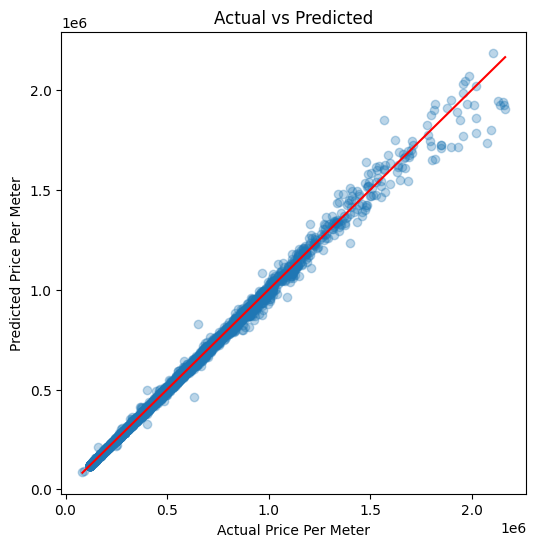

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, preds, alpha=0.3)
plt.xlabel("Actual Price Per Meter")
plt.ylabel("Predicted Price Per Meter")
plt.title("Actual vs Predicted")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         color="red")
plt.show()

### Residual Distribution Analysis

Residuals represent the difference between actual and predicted prices (actual - predicted).

**What this histogram tells us:**
- **Center around zero**: Model is unbiased (no systematic over/under-prediction)
- **Spread**: Width indicates typical prediction error magnitude
- **Shape**: Normal distribution suggests random errors
- **Skew**: Asymmetry indicates systematic bias

**Ideal scenario:** 
- Bell-shaped curve centered at 0
- Most residuals clustered near zero
- Symmetrical distribution

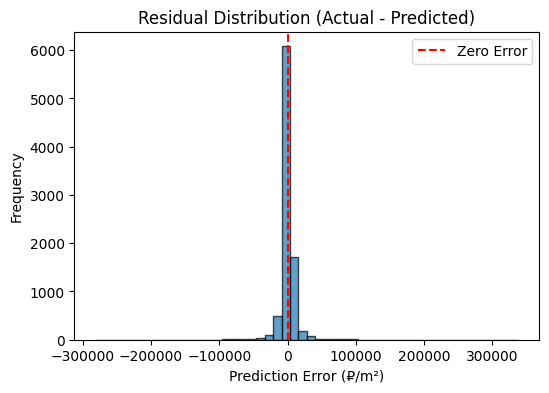

In [113]:
residuals = y_true - preds

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error (₽/m²)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.show()

### Model Prediction Analysis

Let's evaluate how well our model performs on individual samples by comparing actual vs predicted prices per square meter (in Rubles).

**Key metrics we'll examine:**
- **Actual Price**: The real price per m² from the test dataset
- **Predicted Price**: What our CatBoost model estimated
- **Absolute Error**: The raw difference in Rubles (|actual - predicted|)
- **Error %**: Relative error as a percentage of the actual price

This helps us understand:
- Where the model performs well (low error %)
- Where it struggles (high error %)
- The overall distribution of prediction accuracy

In [111]:
import pandas as pd
import numpy as np
from IPython.display import display

print("=== ACTUAL vs PREDICTED PRICE PER M² (RUB) ===\n")

# Create a comparison dataframe with actual vs predicted
comparison_df = pd.DataFrame({
    'Actual Price (₽/m²)': np.round(y_true, 2),
    'Predicted Price (₽/m²)': np.round(preds, 2),
    'Absolute Error (₽)': np.round(np.abs(y_true - preds), 2),
    'Error (%)': np.round(np.abs(y_true - preds) / y_true * 100, 2)
})

# Show random samples
print("=== RANDOM SAMPLES ===")
display(comparison_df.sample(10))

# Show best and worst predictions
print("\n=== BEST PREDICTIONS (Lowest Error %) ===")
display(comparison_df.nsmallest(5, 'Error (%)'))

print("\n=== WORST PREDICTIONS (Highest Error %) ===")
display(comparison_df.nlargest(5, 'Error (%)'))

# Summary statistics
print("\n=== MODEL STATISTICS ===")
print(f"Mean Absolute Error: {comparison_df['Absolute Error (₽)'].mean():,.2f} ₽")
print(f"Mean Relative Error: {comparison_df['Error (%)'].mean():,.2f}%")
print(f"Median Error: {comparison_df['Error (%)'].median():,.2f}%")
print(f"Min Error: {comparison_df['Error (%)'].min():,.2f}%")
print(f"Max Error: {comparison_df['Error (%)'].max():,.2f}%")

=== ACTUAL vs PREDICTED PRICE PER M² (RUB) ===

=== RANDOM SAMPLES ===


,Actual Price (₽/m²),Predicted Price (₽/m²),Absolute Error (₽),Error (%)
40437,465900.00,472161.59,6261.59,1.34
45239,658000.00,663233.27,5233.27,0.80
53235,615800.00,612662.73,3137.27,0.51
39063,691700.00,700773.38,9073.38,1.31
32369,674735.99,673183.44,1552.55,0.23
22254,827135.95,821972.87,5163.08,0.62
12493,581974.64,581763.25,211.38,0.04
36696,211000.00,209578.50,1421.50,0.67
50343,210000.00,208642.02,1357.98,0.65
14552,274538.87,275990.94,1452.07,0.53



=== BEST PREDICTIONS (Lowest Error %) ===


,Actual Price (₽/m²),Predicted Price (₽/m²),Absolute Error (₽),Error (%)
4878,583844.00,583824.67,19.33,0.0
28999,373240.00,373224.41,15.59,0.0
1681,276000.00,275996.62,3.38,0.0
6705,366800.00,366817.40,17.40,0.0
43299,368622.33,368604.71,17.61,0.0



=== WORST PREDICTIONS (Highest Error %) ===


,Actual Price (₽/m²),Predicted Price (₽/m²),Absolute Error (₽),Error (%)
54390,161280.0,209622.69,48342.69,29.97
56507,630600.0,462007.46,168592.54,26.74
4419,654700.0,826981.88,172281.88,26.31
13862,400000.0,499171.00,99171.00,24.79
48807,403200.0,325450.31,77749.69,19.28



=== MODEL STATISTICS ===
Mean Absolute Error: 6,385.95 ₽
Mean Relative Error: 1.14%
Median Error: 0.83%
Min Error: 0.00%
Max Error: 29.97%


### Model Artifacts Export

Saving the trained model and feature metadata for production deployment.

**Exported Files:**
- **`catboost_price_model_final.cbm`** - Trained CatBoost model binary
- **`model_features.json`** - Complete list of feature names in exact order (29 features)
- **`categorical_features.json`** - List of categorical feature names for proper encoding

**Deployment Usage:**
```python
# Load model
model = CatBoostRegressor()
model.load_model("catboost_price_model_final.cbm")

# Load feature lists
with open("model_features.json", "r") as f:
    features = json.load(f)
with open("categorical_features.json", "r") as f:
    cat_features = json.load(f)

In [114]:
model.save_model("catboost_price_model_final.cbm")

import json

with open("model_features.json", "w") as f:
    json.dump(list(X.columns), f)

with open("categorical_features.json", "w") as f:
    json.dump(cat_features, f)

print("Artifacts saved successfully.")

Artifacts saved successfully.
